## 📊 Final Analysis: Best Retriever for Loan Complaint Data

Based on our comprehensive evaluation using Ragas metrics and LangSmith cost tracking, here's the complete analysis:

# Advanced Retrieval with LangChain

In the following notebook, we'll explore various methods of advanced retrieval using LangChain!

We'll touch on:

- Naive Retrieval
- Best-Matching 25 (BM25)
- Multi-Query Retrieval
- Parent-Document Retrieval
- Contextual Compression (a.k.a. Rerank)
- Ensemble Retrieval
- Semantic chunking

We'll also discuss how these methods impact performance on our set of documents with a simple RAG chain.

There will be two breakout rooms:

- 🤝 Breakout Room Part #1
  - Task 1: Getting Dependencies!
  - Task 2: Data Collection and Preparation
  - Task 3: Setting Up QDrant!
  - Task 4-10: Retrieval Strategies
- 🤝 Breakout Room Part #2
  - Activity: Evaluate with Ragas

# 🤝 Breakout Room Part #1

## Task 1: Getting Dependencies!

We're going to need a few specific LangChain community packages, like OpenAI (for our [LLM](https://platform.openai.com/docs/models) and [Embedding Model](https://platform.openai.com/docs/guides/embeddings)) and Cohere (for our [Reranker](https://cohere.com/rerank)).

We'll also provide our OpenAI key, as well as our Cohere API key.

In [1]:
import os
import getpass

# os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API Key:")
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

In [2]:
# os.environ["COHERE_API_KEY"] = getpass.getpass("Cohere API Key:")
os.environ["COHERE_API_KEY"] = os.getenv("COHERE_API_KEY")

## Task 2: Data Collection and Preparation

We'll be using our Loan Data once again - this time the strutured data available through the CSV!

### Data Preparation

We want to make sure all our documents have the relevant metadata for the various retrieval strategies we're going to be applying today.

In [3]:
from langchain_community.document_loaders.csv_loader import CSVLoader
from datetime import datetime, timedelta

loader = CSVLoader(
    file_path=f"./data/complaints.csv",
    metadata_columns=[
      "Date received", 
      "Product", 
      "Sub-product", 
      "Issue", 
      "Sub-issue", 
      "Consumer complaint narrative", 
      "Company public response", 
      "Company", 
      "State", 
      "ZIP code", 
      "Tags", 
      "Consumer consent provided?", 
      "Submitted via", 
      "Date sent to company", 
      "Company response to consumer", 
      "Timely response?", 
      "Consumer disputed?", 
      "Complaint ID"
    ]
)

loan_complaint_data = loader.load()

for doc in loan_complaint_data:
    doc.page_content = doc.metadata["Consumer complaint narrative"]

Let's look at an example document to see if everything worked as expected!

In [4]:
loan_complaint_data[0]

Document(metadata={'source': './data/complaints.csv', 'row': 0, 'Date received': '03/27/25', 'Product': 'Student loan', 'Sub-product': 'Federal student loan servicing', 'Issue': 'Dealing with your lender or servicer', 'Sub-issue': 'Trouble with how payments are being handled', 'Consumer complaint narrative': "The federal student loan COVID-19 forbearance program ended in XX/XX/XXXX. However, payments were not re-amortized on my federal student loans currently serviced by Nelnet until very recently. The new payment amount that is effective starting with the XX/XX/XXXX payment will nearly double my payment from {$180.00} per month to {$360.00} per month. I'm fortunate that my current financial position allows me to be able to handle the increased payment amount, but I am sure there are likely many borrowers who are not in the same position. The re-amortization should have occurred once the forbearance ended to reduce the impact to borrowers.", 'Company public response': 'None', 'Company'

## Task 3: Setting up QDrant!

Now that we have our documents, let's create a QDrant VectorStore with the collection name "LoanComplaints".

We'll leverage OpenAI's [`text-embedding-3-small`](https://openai.com/blog/new-embedding-models-and-api-updates) because it's a very powerful (and low-cost) embedding model.

> NOTE: We'll be creating additional vectorstores where necessary, but this pattern is still extremely useful.

In [5]:
from langchain_community.vectorstores import Qdrant
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

vectorstore = Qdrant.from_documents(
    loan_complaint_data,
    embeddings,
    location=":memory:",
    collection_name="LoanComplaints"
)

## Task 4: Naive RAG Chain

Since we're focusing on the "R" in RAG today - we'll create our Retriever first.

### R - Retrieval

This naive retriever will simply look at each review as a document, and use cosine-similarity to fetch the 10 most relevant documents.

> NOTE: We're choosing `10` as our `k` here to provide enough documents for our reranking process later

In [6]:
naive_retriever = vectorstore.as_retriever(search_kwargs={"k" : 10})

### A - Augmented

We're going to go with a standard prompt for our simple RAG chain today! Nothing fancy here, we want this to mostly be about the Retrieval process.

In [7]:
from langchain_core.prompts import ChatPromptTemplate

RAG_TEMPLATE = """\
You are a helpful and kind assistant. Use the context provided below to answer the question.

If you do not know the answer, or are unsure, say you don't know.

Query:
{question}

Context:
{context}
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_TEMPLATE)

### G - Generation

We're going to leverage `gpt-4.1-nano` as our LLM today, as - again - we want this to largely be about the Retrieval process.

In [8]:
from langchain_openai import ChatOpenAI

chat_model = ChatOpenAI(model="gpt-4.1-nano")

### LCEL RAG Chain

We're going to use LCEL to construct our chain.

> NOTE: This chain will be exactly the same across the various examples with the exception of our Retriever!

In [9]:
from langchain_core.runnables import RunnablePassthrough
from operator import itemgetter
from langchain_core.output_parsers import StrOutputParser

naive_retrieval_chain = (
    # INVOKE CHAIN WITH: {"question" : "<<SOME USER QUESTION>>"}
    # "question" : populated by getting the value of the "question" key
    # "context"  : populated by getting the value of the "question" key and chaining it into the base_retriever
    {"context": itemgetter("question") | naive_retriever, "question": itemgetter("question")}
    # "context"  : is assigned to a RunnablePassthrough object (will not be called or considered in the next step)
    #              by getting the value of the "context" key from the previous step
    | RunnablePassthrough.assign(context=itemgetter("context"))
    # "response" : the "context" and "question" values are used to format our prompt object and then piped
    #              into the LLM and stored in a key called "response"
    # "context"  : populated by getting the value of the "context" key from the previous step
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's see how this simple chain does on a few different prompts.

> NOTE: You might think that we've cherry picked prompts that showcase the individual skill of each of the retrieval strategies - you'd be correct!

In [10]:
naive_retrieval_chain.invoke({"question" : "What is the most common issue with loans?"})["response"].content

"Based on the provided complaints, the most common issues with student loans appear to be related to mismanagement and errors by loan servicers, including:\n\n- Errors in loan balances and account information.\n- Incorrect reporting of loan status and late payments.\n- Problems applying payments correctly, especially toward principal versus interest.\n- Lack of communication or notifications about transfer of loan servicers.\n- Unauthorized or unnotified transfer of loans.\n- Difficulty in obtaining accurate information, leading to costs and credit impacts.\n- Disputes over interest capitalization, wrong balances, and handling of forbearance.\n\nOverall, a predominant theme is that issues with loan servicing, such as errors, misapplication of payments, and lack of transparent communication, are most commonly reported problems.\n\nLet me know if you'd like more details or insights!"

In [11]:
naive_retrieval_chain.invoke({"question" : "Did any complaints not get handled in a timely manner?"})["response"].content

'Based on the provided data, yes, some complaints did not get handled in a timely manner. Specifically, the complaint filed with MOHELA (Complaint ID: 12709087) on 03/28/25 was marked as "Not timely," indicating it was delayed beyond the expected response time. Additionally, multiple complaints reflect delays or failures in resolution or response, such as the one with Maximus Federal Services, Inc. (Complaint ID: 13160766), which was marked as "Yes" for timely response, but the issues described suggest ongoing unresolved problems. Overall, at least one complaint was explicitly noted as not handled promptly.'

In [12]:
naive_retrieval_chain.invoke({"question" : "Why did people fail to pay back their loans?"})["response"].content

'People failed to pay back their loans primarily due to a combination of factors highlighted in the complaints:\n\n1. **Lack of clear communication and notification:** Many borrowers were not properly informed about when their repayment obligations would resume, transfer of loan servicers, or changes in payment requirements. For example, several complainants reported not receiving notices about loan transfers or the start of repayment, leading to unintentional delinquency and negative credit impacts.\n\n2. **Compounding interest and unfavorable repayment options:** Borrowers faced growing debts because interest continued to accrue even during forbearance or deferment periods. Lowering monthly payments often resulted in interest compounding, which increased the total debt over time, making it difficult or impossible to pay off the loans fully.\n\n3. **Inadequate or confusing loan management practices:** Complaints indicate mismanagement by loan servicers, including failing to provide de

Overall, this is not bad! Let's see if we can make it better!

## Task 5: Best-Matching 25 (BM25) Retriever

Taking a step back in time - [BM25](https://www.nowpublishers.com/article/Details/INR-019) is based on [Bag-Of-Words](https://en.wikipedia.org/wiki/Bag-of-words_model) which is a sparse representation of text.

In essence, it's a way to compare how similar two pieces of text are based on the words they both contain.

This retriever is very straightforward to set-up! Let's see it happen down below!


In [13]:
from langchain_community.retrievers import BM25Retriever

bm25_retriever = BM25Retriever.from_documents(loan_complaint_data, )

We'll construct the same chain - only changing the retriever.

In [14]:
bm25_retrieval_chain = (
    {"context": itemgetter("question") | bm25_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's look at the responses!

In [15]:
bm25_retrieval_chain.invoke({"question" : "What is the most common issue with loans?"})["response"].content

"Based on the provided context, the most common issue with loans appears to be problems related to dealing with lenders or servicers. Specifically, issues such as incorrect or inadequate information about the loan (e.g., loan balance, repayment plans, interest calculations), difficulties in applying payments correctly (e.g., applying additional funds to principal), and disputes over fees or charges seem prevalent. Many complaints involve the servicer's handling of loan details, misrepresentation or bad information provided to borrowers, and challenges in managing or understanding loan terms."

In [16]:
bm25_retrieval_chain.invoke({"question" : "Did any complaints not get handled in a timely manner?"})["response"].content

"Based on the provided complaints, all of the responses to the complaints indicate they were handled in a timely manner. Specifically, each complaint shows a 'Timely response?' status of 'Yes.' Therefore, there is no evidence in this data that any complaints did not get handled in a timely manner."

In [17]:
bm25_retrieval_chain.invoke({"question" : "Why did people fail to pay back their loans?"})["response"].content

'People failed to pay back their loans for various reasons, including problems with their payment plans, inadequate communication from lenders or servicers, errors or delays in processing forbearances or deferments, and issues related to unfair or deceptive practices by loan companies. Some specific challenges noted in the complaints include being steered into wrong types of forbearances, unresponsive loan servicers, automatic payments being canceled without notification, and difficulties in resolving billing errors or understanding their repayment obligations. These issues can lead to missed payments, account delinquencies, and negative impacts on credit scores.'

It's not clear that this is better or worse, if only we had a way to test this (SPOILERS: We do, the second half of the notebook will cover this)

#### ❓ Question #1:

Give an example query where BM25 is better than embeddings and justify your answer.

### ✅ Answer:

BM25 (Best Matching 25) excels over embedding-based retrieval when dealing with queries that require exact keyword matching, specific identifiers, or rare/technical terms. Here's a detailed example:

**Example Query:** `"Complaint ID 12686613 Nelnet forbearance XX/XX/XXXX"`

### Detailed Justification:

**1. Why BM25 Performs Better:**
- **Exact Term Matching**: BM25 uses term frequency (TF) and inverse document frequency (IDF) to find documents containing the exact terms. It will give high scores to documents containing "12686613", "Nelnet", and "forbearance".
- **Rare Term Importance**: The complaint ID "12686613" is extremely rare (appears in only one document), so BM25's IDF component gives it very high weight.
- **No Semantic Confusion**: BM25 doesn't try to find "similar" complaint IDs - it looks for the exact match.

**2. Why Embeddings Struggle:**
- **Number Representation**: Embedding models often poorly represent specific numbers like "12686613". During training, they learn semantic relationships, not memorize specific IDs.
- **Semantic Averaging**: Embeddings create a dense vector representing the "meaning" of the entire query, which can dilute the importance of the specific ID.
- **No Exact Match Guarantee**: Even if semantically similar, embeddings might return complaints about other Nelnet issues or different forbearance cases, missing the specific requested complaint.

**3. Real-World Example from the Dataset:**
When searching for this specific complaint, BM25 would directly retrieve:
```
"The federal student loan COVID-19 forbearance program ended in XX/XX/XXXX. However, payments were not re-amortized on my federal student loans currently serviced by Nelnet..."
```

While embeddings might return semantically related but different complaints about:
- Other Nelnet payment issues (different complaint IDs)
- Other forbearance problems (different companies)
- General payment re-amortization issues

**4. When to Use Each:**
- **Use BM25**: Legal document search, finding specific case numbers, product SKUs, error codes, technical documentation with specific terms
- **Use Embeddings**: Conceptual queries like "why are people unhappy with their loans", finding similar problems regardless of specific wording

## Task 6: Contextual Compression (Using Reranking)

Contextual Compression is a fairly straightforward idea: We want to "compress" our retrieved context into just the most useful bits.

There are a few ways we can achieve this - but we're going to look at a specific example called reranking.

The basic idea here is this:

- We retrieve lots of documents that are very likely related to our query vector
- We "compress" those documents into a smaller set of *more* related documents using a reranking algorithm.

We'll be leveraging Cohere's Rerank model for our reranker today!

All we need to do is the following:

- Create a basic retriever
- Create a compressor (reranker, in this case)

That's it!

Let's see it in the code below!

In [18]:
from langchain.retrievers.contextual_compression import ContextualCompressionRetriever
from langchain_cohere import CohereRerank

compressor = CohereRerank(model="rerank-v3.5")
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=naive_retriever
)

Let's create our chain again, and see how this does!

In [19]:
contextual_compression_retrieval_chain = (
    {"context": itemgetter("question") | compression_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

In [20]:
contextual_compression_retrieval_chain.invoke({"question" : "What is the most common issue with loans?"})["response"].content

'Based on the provided complaints, a common issue with loans, particularly student loans, is dealing with the lender or servicer, which often involves errors or misconduct. Specific problems include receiving bad or incorrect information about the loan, errors in loan balances, misapplied payments, wrongful denials of payment plans, lack of communication or documentation, unauthorized transfers of loans, and mishandling of personal information. \n\nTherefore, the most common issue appears to be problems related to the administration and communication by lenders or servicers, leading to errors and disputes regarding loan balances, payment information, and privacy concerns.'

In [21]:
contextual_compression_retrieval_chain.invoke({"question" : "Did any complaints not get handled in a timely manner?"})["response"].content

'Based on the provided context, at least one complaint was handled in a timely manner, as indicated by the responses stating "Timely response? Yes." However, there is also a complaint that has been open for nearly 18 months without resolution, which suggests that some complaints may not have been handled in a timely manner. Overall, while some complaints were addressed promptly, others experienced significant delays.'

In [22]:
contextual_compression_retrieval_chain.invoke({"question" : "Why did people fail to pay back their loans?"})["response"].content

'People failed to pay back their loans primarily due to a combination of lack of understanding about the repayment requirements, insufficient communication from lenders or servicers, and the increasing burden of interest. Many borrowers were unaware that they would need to repay their loans and did not receive clear or accurate information about repayment obligations, interest accrual, or account status. Additionally, some experienced issues such as incorrect account information, lack of notifications about due payments, and difficulty navigating the online systems. The accumulation of interest during deferment or forbearance periods, combined with limited options to effectively manage or reduce the debt, further contributed to the inability to repay the loans fully. Overall, inadequate information, poor communication, and the growing interest expenses led to many borrowers struggling to meet their loan repayment obligations.'

We'll need to rely on something like Ragas to help us get a better sense of how this is performing overall - but it "feels" better!

## Task 7: Multi-Query Retriever

Typically in RAG we have a single query - the one provided by the user.

What if we had....more than one query!

In essence, a Multi-Query Retriever works by:

1. Taking the original user query and creating `n` number of new user queries using an LLM.
2. Retrieving documents for each query.
3. Using all unique retrieved documents as context

So, how is it to set-up? Not bad! Let's see it down below!



In [23]:
from langchain.retrievers.multi_query import MultiQueryRetriever

multi_query_retriever = MultiQueryRetriever.from_llm(
    retriever=naive_retriever, llm=chat_model
)

In [24]:
multi_query_retrieval_chain = (
    {"context": itemgetter("question") | multi_query_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

In [25]:
multi_query_retrieval_chain.invoke({"question" : "What is the most common issue with loans?"})["response"].content

'The most common issue with loans, based on the provided complaints, appears to be problems related to dealing with lenders or servicers, including errors in loan balances, misapplied payments, incorrect or bad information about loans, and poor communication. Many complaints also highlight issues like unauthorized transfers of loans, difficulty in obtaining accurate loan details, and failures in providing proper guidance or support.\n\nIn summary, the most frequent issue is **"Dealing with your lender or servicer,"** particularly involving errors, mismanagement, misinformation, and inadequate customer service.'

In [26]:
multi_query_retrieval_chain.invoke({"question" : "Did any complaints not get handled in a timely manner?"})["response"].content

'Based on the provided complaints data, yes, there are multiple complaints indicating that complaints were not handled in a timely manner. Specifically, at least one complaint (Complaint ID: 12709087) explicitly states that the response was delayed by over 18 months without resolution, and another (Complaint ID: 12973003) mentions that it took over 2-3 weeks to resolve an issue. Additionally, many complaints mention delays, ongoing issues, and lack of response over extended periods, suggesting that some complaints did not get handled promptly.'

In [27]:
multi_query_retrieval_chain.invoke({"question" : "Why did people fail to pay back their loans?"})["response"].content

'People failed to pay back their loans primarily due to a combination of factors highlighted in the complaints:\n\n1. **Lack of Clear Information and Communication:** Many borrowers were not adequately informed about their repayment obligations, options for deferment, forbearance, income-driven repayment plans, or loan forgiveness programs. This often resulted in players being unaware of when payments were due or the consequences of missed payments.\n\n2. **Interest Accumulation and Capitalization:** Borrowers were often placed into forbearance without understanding that interest would continue to accrue and compound, increasing the total amount owed over time. Some complaints describe loans ballooning due to unintentional interest capitalization.\n\n3. **Mismanagement and Errors by Servicers:** Several complaints mention errors, misapplied payments, wrong account balances, or incorrect reporting to credit bureaus, which can hinder borrowers’ ability to repay properly.\n\n4. **Steering

#### ❓ Question #2:

Explain how generating multiple reformulations of a user query can improve recall.

### ✅ Answer:

Generating multiple reformulations of a user query significantly improves recall by capturing different ways the same information might be expressed in the documents. Here's a detailed explanation:

### What is Multi-Query Retrieval?

Multi-Query Retrieval works by:
1. Taking the original user query
2. Using an LLM to generate 3-5 alternative versions of the same question
3. Running retrieval for each query variant
4. Combining all unique retrieved documents

### How It Improves Recall:

**1. Vocabulary Mismatch Problem:**
- **Original Query**: "Why did people fail to pay back their loans?"
- **Document Language**: Might use terms like "default", "delinquency", "non-payment", "missed payments", "account past due"
- **Solution**: Multiple queries capture these variations

**2. Example with Reformulations:**

Original Query: **"Why did people fail to pay back their loans?"**

LLM-Generated Reformulations:
- "What caused borrowers to default on their loans?"
- "What are the reasons for loan delinquency?"
- "Why couldn't consumers make their loan payments?"
- "What led to non-payment of student loans?"

**3. How Each Query Finds Different Documents:**

```python
# Query 1: "fail to pay back" might retrieve:
- Documents mentioning "failure to repay"
- Documents about "unable to pay back"

# Query 2: "default" might retrieve:
- Legal documents using formal terminology
- Documents about "defaulted loans"

# Query 3: "delinquency" might retrieve:
- Official reports using banking terminology
- Documents about "delinquent accounts"

# Query 4: "couldn't make payments" might retrieve:
- Personal narratives using casual language
- Documents about "missed payments"
```

**4. Real-World Impact on Recall:**

From the loan complaints dataset:
- **Single Query**: Might retrieve 10 documents mentioning "fail to pay"
- **Multi-Query**: Could retrieve 25-30 unique documents by finding:
  - Complaints using "default" (formal language)
  - Complaints using "can't afford" (informal language)
  - Complaints using "delinquent" (technical language)
  - Complaints using "behind on payments" (colloquial language)

**5. Mathematical Perspective:**

If each query has 70% recall individually but captures slightly different document sets:
- Single query recall: 70%
- Multiple queries combined: Could achieve 85-95% recall due to union of results

**6. Benefits:**
- **Synonym Coverage**: Captures different ways of expressing the same concept
- **Perspective Diversity**: Formal vs. informal language, technical vs. layman terms
- **Context Variations**: Different phrasings reveal different aspects of the same issue
- **Robustness**: Less sensitive to specific word choices in the original query

**7. Trade-offs:**
- **Increased Latency**: Multiple retrieval calls take more time
- **Higher Computational Cost**: More embedding comparisons
- **Potential Noise**: May retrieve some less relevant documents
- **Deduplication Needed**: Same document might be retrieved multiple times

## Task 8: Parent Document Retriever

A "small-to-big" strategy - the Parent Document Retriever works based on a simple strategy:

1. Each un-split "document" will be designated as a "parent document" (You could use larger chunks of document as well, but our data format allows us to consider the overall document as the parent chunk)
2. Store those "parent documents" in a memory store (not a VectorStore)
3. We will chunk each of those documents into smaller documents, and associate them with their respective parents, and store those in a VectorStore. We'll call those "child chunks".
4. When we query our Retriever, we will do a similarity search comparing our query vector to the "child chunks".
5. Instead of returning the "child chunks", we'll return their associated "parent chunks".

Okay, maybe that was a few steps - but the basic idea is this:

- Search for small documents
- Return big documents

The intuition is that we're likely to find the most relevant information by limiting the amount of semantic information that is encoded in each embedding vector - but we're likely to miss relevant surrounding context if we only use that information.

Let's start by creating our "parent documents" and defining a `RecursiveCharacterTextSplitter`.

In [28]:
from langchain.retrievers import ParentDocumentRetriever
from langchain.storage import InMemoryStore
from langchain_text_splitters import RecursiveCharacterTextSplitter
from qdrant_client import QdrantClient, models

parent_docs = loan_complaint_data
child_splitter = RecursiveCharacterTextSplitter(chunk_size=750)

We'll need to set up a new QDrant vectorstore - and we'll use another useful pattern to do so!

> NOTE: We are manually defining our embedding dimension, you'll need to change this if you're using a different embedding model.

In [29]:
from langchain_qdrant import QdrantVectorStore

client = QdrantClient(location=":memory:")

client.create_collection(
    collection_name="full_documents",
    vectors_config=models.VectorParams(size=1536, distance=models.Distance.COSINE)
)

parent_document_vectorstore = QdrantVectorStore(
    collection_name="full_documents", embedding=OpenAIEmbeddings(model="text-embedding-3-small"), client=client
)

Now we can create our `InMemoryStore` that will hold our "parent documents" - and build our retriever!

In [30]:
store = InMemoryStore()

parent_document_retriever = ParentDocumentRetriever(
    vectorstore = parent_document_vectorstore,
    docstore=store,
    child_splitter=child_splitter,
)

By default, this is empty as we haven't added any documents - let's add some now!

In [31]:
parent_document_retriever.add_documents(parent_docs, ids=None)

We'll create the same chain we did before - but substitute our new `parent_document_retriever`.

In [32]:
parent_document_retrieval_chain = (
    {"context": itemgetter("question") | parent_document_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's give it a whirl!

In [33]:
parent_document_retrieval_chain.invoke({"question" : "What is the most common issue with loans?"})["response"].content

'The most common issue with loans, based on the provided complaints, appears to involve problems with federal student loan servicing, including errors in loan balances, misapplied payments, wrongful denials of payment plans, and issues related to credit reporting and account information. Many complaints highlight systemic breakdowns, misinformation, and misconduct by loan servicers.'

In [34]:
parent_document_retrieval_chain.invoke({"question" : "Did any complaints not get handled in a timely manner?"})["response"].content

'Based on the provided information, it appears that several complaints did not receive a timely response. Specifically, the complaints with Complaint IDs 12709087 and 12935889 mention that the responses from the companies—MOHELA—were "Closed with explanation" and the response times were marked as "No" for being timely. Additionally, the complaint with ID 13205525, submitted to Nelnet, was responded to within the same day ("Yes" for timely response). \n\nTherefore, yes, some complaints did not get handled in a timely manner.'

In [35]:
parent_document_retrieval_chain.invoke({"question" : "Why did people fail to pay back their loans?"})["response"].content

'People failed to pay back their loans primarily due to a combination of factors such as financial hardship, mismanagement by educational institutions and loan servicers, lack of proper information or communication about repayment obligations, and issues related to the long-term financial consequences of taking on student debt. Specifically, some individuals faced severe financial difficulties after graduation, which made consistent repayment difficult. Others experienced problems with loan servicing agencies, such as lack of notification, inability to establish payment plans, or questions about the legitimacy of their debt. Additionally, in some cases, the failure to receive adequate counseling or transparent information about repayment terms, debt forgiveness options, or institutional stability contributed to their inability to repay their loans effectively.'

Overall, the performance *seems* largely the same. We can leverage a tool like [Ragas]() to more effectively answer the question about the performance.

## Task 9: Ensemble Retriever

In brief, an Ensemble Retriever simply takes 2, or more, retrievers and combines their retrieved documents based on a rank-fusion algorithm.

In this case - we're using the [Reciprocal Rank Fusion](https://plg.uwaterloo.ca/~gvcormac/cormacksigir09-rrf.pdf) algorithm.

Setting it up is as easy as providing a list of our desired retrievers - and the weights for each retriever.

In [36]:
from langchain.retrievers import EnsembleRetriever

retriever_list = [bm25_retriever, naive_retriever, parent_document_retriever, compression_retriever, multi_query_retriever]
equal_weighting = [1/len(retriever_list)] * len(retriever_list)

ensemble_retriever = EnsembleRetriever(
    retrievers=retriever_list, weights=equal_weighting
)

We'll pack *all* of these retrievers together in an ensemble.

In [37]:
ensemble_retrieval_chain = (
    {"context": itemgetter("question") | ensemble_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's look at our results!

In [38]:
ensemble_retrieval_chain.invoke({"question" : "What is the most common issue with loans?"})["response"].content

'The most common issue with loans, based on the provided complaints, appears to be dealing with inaccuracies and mishandling by loan servicers, including errors in loan balances, misapplied payments, wrongful denials of repayment plans, incorrect reporting of account status, and improper classification of loans. Many complaints also involve receiving bad information, lack of transparency, delays or failure in processing repayment options like income-driven plans, and errors that impact credit reports and scores. \n\nIn summary, a key pattern is systemic errors and mismanagement by loan servicers leading to financial hardship and credit issues for borrowers.'

In [39]:
ensemble_retrieval_chain.invoke({"question" : "Did any complaints not get handled in a timely manner?"})["response"].content

'Based on the provided complaints data, yes, some complaints indicate that issues were not handled in a timely manner. Specifically:\n\n- In complaint ID 12935889 (Maximus Federal Services, TX), the response was marked as "No" for timely response, indicating it was not handled promptly.\n- Similarly, complaint ID 12668396 (Mohela, NJ) also was "Not timely," as the response was "Closed with explanation" and marked as "No" for timely response.\n- Several other complaints mention delays, long wait times, or ongoing unresolved issues that have persisted for months or over a year, which suggests they were not handled in a timely manner.\n\nIn conclusion, yes, there were complaints that did not get handled in a timely fashion, as explicitly noted in some records and implied by the ongoing unresolved nature of others.\n\nIf you need more specific details or a summary, feel free to ask!'

In [40]:
ensemble_retrieval_chain.invoke({"question" : "Why did people fail to pay back their loans?"})["response"].content

'People often failed to pay back their loans due to a variety of systemic and individual challenges, including:\n\n1. **Lack of clear communication and timely notification:** Many borrowers reported not being properly informed when repayment was to resume, especially after transfers between loan servicers. They did not receive notices about due dates, changes in payment plans, or requirements, leading to unintentional delinquency.\n\n2. **Difficulty in managing interest and repayment options:** Borrowers described that forbearance and deferment options, while accessible, led to continued interest accumulation, often making it harder to pay down the principal and extending the repayment period. Many also lacked awareness of income-driven repayment or loan forgiveness programs that could make repayment more manageable.\n\n3. **Financial hardships and unexpected circumstances:** Borrowers faced significant hardships such as unemployment, disability, health issues, homelessness, or economi

## Task 10: Semantic Chunking

While this is not a retrieval method - it *is* an effective way of increasing retrieval performance on corpora that have clean semantic breaks in them.

Essentially, Semantic Chunking is implemented by:

1. Embedding all sentences in the corpus.
2. Combining or splitting sequences of sentences based on their semantic similarity based on a number of [possible thresholding methods](https://python.langchain.com/docs/how_to/semantic-chunker/):
  - `percentile`
  - `standard_deviation`
  - `interquartile`
  - `gradient`
3. Each sequence of related sentences is kept as a document!

Let's see how to implement this!

We'll use the `percentile` thresholding method for this example which will:

Calculate all distances between sentences, and then break apart sequences of setences that exceed a given percentile among all distances.

In [41]:
from langchain_experimental.text_splitter import SemanticChunker

semantic_chunker = SemanticChunker(
    embeddings,
    breakpoint_threshold_type="percentile"
)

Now we can split our documents.

In [42]:
semantic_documents = semantic_chunker.split_documents(loan_complaint_data[:20])

Let's create a new vector store.

In [43]:
semantic_vectorstore = Qdrant.from_documents(
    semantic_documents,
    embeddings,
    location=":memory:",
    collection_name="Loan_Complaint_Data_Semantic_Chunks"
)

We'll use naive retrieval for this example.

In [44]:
semantic_retriever = semantic_vectorstore.as_retriever(search_kwargs={"k" : 10})

Finally we can create our classic chain!

In [45]:
semantic_retrieval_chain = (
    {"context": itemgetter("question") | semantic_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

And view the results!

In [46]:
semantic_retrieval_chain.invoke({"question" : "What is the most common issue with loans?"})["response"].content

'Based on the provided data, the most common issues with loans tend to involve difficulties with repayment, such as struggling to repay the loan, problems with payment plans, or incorrect payment amounts. Many complaints highlight issues like the inability to get clear information from lenders or servicers, errors in reporting or account status, and disputes over illegal or improper reporting, especially related to the handling and reporting of student loans.'

In [47]:
semantic_retrieval_chain.invoke({"question" : "Did any complaints not get handled in a timely manner?"})["response"].content

'Based on the provided complaints, it appears that several complaints were marked as "Closed with explanation" and have a response indicating they were handled in a timely manner ("Timely response?": "Yes"). For example, complaints involving Nelnet Inc. from IN and NM, and Maximus Federal Services from WA, all indicated responses were timely.\n\nHowever, the context also mentions multiple complaints where consumers did not receive responses or did not have their complaints handled promptly, such as the case with EdFinancial Services from NY, which was also marked as "Closed with explanation," but the narrative suggests ongoing issues and disputes.\n\nSince the specific question is whether any complaints did **not** get handled in a timely manner, the overall data suggests that most complaints labeled "Timely response: Yes" were addressed promptly. Those marked "Company response to consumer: None" or involving ongoing disputes could imply delayed or unhandled responses, but without expl

In [48]:
semantic_retrieval_chain.invoke({"question" : "Why did people fail to pay back their loans?"})["response"].content

'People may fail to pay back their loans for various reasons, including:\n\n1. Lack of clear communication or transparency from lenders or servicers, leading to confusion about loan status, repayment terms, or updates (e.g., receiving bad information about loans, difficulties logging in, or unclear notices of servicer changes).\n2. Administrative or procedural issues, such as delays or errors in recording payments, mismanagement of documentation, or unverified legitimacy of debts.\n3. Disputes over loan information, including incorrect reports, missing payments, or unresolved documentation issues.\n4. Financial hardship or changes in personal circumstances that make it difficult for borrowers to keep up with payments.\n5. Allegations of improper practices by loan servicers, such as stalling tactics, misreporting, or violating legal protections, which can hinder repayment efforts.\n6. Confusion about loan terms, especially after program changes like the end of forbearance or loan transf

#### ❓ Question #3:

If sentences are short and highly repetitive (e.g., FAQs), how might semantic chunking behave, and how would you adjust the algorithm?

### ✅ Answer:

When dealing with short, highly repetitive sentences like FAQs, semantic chunking can exhibit problematic behaviors that require specific adjustments. Here's a detailed analysis:

### How Semantic Chunking Would Behave with FAQs:

**1. Over-Fragmentation Problem:**
```
Example FAQ content:
Q: How do I reset my password?
A: Click on "Forgot Password" on the login page.
Q: How do I change my email?
A: Go to Settings > Profile > Email.
Q: How do I update my payment method?
A: Navigate to Settings > Billing > Payment Methods.
```

**Behavior**: Each Q&A pair might be split into separate chunks because:
- Short sentences have less semantic overlap
- Questions have different semantic signatures than answers
- Similar questions might not be similar enough to group together

**2. Similarity Threshold Issues:**

With `percentile` breakpoint threshold:
- **Problem**: Short sentences create extreme distance distributions
- **Result**: Either everything groups together (threshold too high) or nothing groups (threshold too low)
- **Example**: All "How do I..." questions might incorrectly merge into one massive chunk

**3. Context Loss:**
```
Original FAQ:
Q: What is forbearance?
A: A temporary pause on loan payments.

After chunking might become:
Chunk 1: "What is forbearance?"
Chunk 2: "A temporary pause on loan payments."
```
The Q&A relationship is lost!

### Adjustments to the Algorithm:

**1. Implement Structural Awareness:**
```python
# Instead of pure semantic chunking, use pattern recognition
def structure_aware_chunking(documents):
    chunks = []
    current_chunk = []
    
    for sentence in documents:
        if sentence.startswith("Q:") and current_chunk:
            # New question found, save previous Q&A pair
            chunks.append(" ".join(current_chunk))
            current_chunk = [sentence]
        else:
            current_chunk.append(sentence)
    
    return chunks
```

**2. Adjust Similarity Thresholds:**
```python
# For FAQs, use different thresholds
semantic_chunker = SemanticChunker(
    embeddings,
    breakpoint_threshold_type="percentile",
    breakpoint_threshold_amount=95  # Higher threshold for short texts
)
```

**3. Use Hybrid Approach:**
```python
# Combine structural and semantic signals
def hybrid_faq_chunking(documents):
    # Step 1: Group by structure (Q&A pairs)
    qa_pairs = group_qa_pairs(documents)
    
    # Step 2: Apply semantic chunking on grouped pairs
    semantic_groups = []
    for qa_pair in qa_pairs:
        # Group similar Q&A pairs together
        semantic_groups.extend(
            semantic_chunker.split_text(qa_pair)
        )
    
    return semantic_groups
```

**4. Implement Minimum Chunk Size:**
```python
# Ensure chunks have minimum context
MIN_CHUNK_SIZE = 3  # At least Q + A + buffer

def adjusted_semantic_chunking(sentences):
    chunks = semantic_chunker.split_text(sentences)
    
    # Merge chunks that are too small
    merged_chunks = []
    current_chunk = []
    
    for chunk in chunks:
        current_chunk.append(chunk)
        if len(current_chunk) >= MIN_CHUNK_SIZE:
            merged_chunks.append(" ".join(current_chunk))
            current_chunk = []
    
    return merged_chunks
```

**5. Use Different Breakpoint Methods:**

For FAQs, consider switching from `percentile` to:
- **`gradient`**: Better for detecting sharp transitions between topics
- **`standard_deviation`**: More stable with repetitive content
- **Custom thresholds**: Based on FAQ structure

```python
# Better for FAQs
semantic_chunker = SemanticChunker(
    embeddings,
    breakpoint_threshold_type="gradient",
    number_of_chunks=None  # Let gradient method decide
)
```

**6. Pre-processing Strategy:**
```python
def preprocess_faqs(faq_text):
    # Group Q&A pairs first
    qa_pairs = []
    lines = faq_text.split('\n')
    
    i = 0
    while i < len(lines):
        if lines[i].startswith('Q:'):
            question = lines[i]
            answer = lines[i+1] if i+1 < len(lines) else ""
            qa_pairs.append(f"{question} {answer}")
            i += 2
        else:
            i += 1
    
    return qa_pairs
```

### Recommended Solution for FAQs:

1. **Don't rely solely on semantic chunking** - Use structural patterns
2. **Preserve Q&A relationships** - Never separate questions from their answers
3. **Group similar FAQs** - Combine semantic similarity with structural patterns
4. **Set appropriate thresholds** - Higher thresholds for short, repetitive content
5. **Consider alternative chunking** - Fixed-size or pattern-based chunking might work better

### Example Implementation:
```python
# For FAQ-specific content
class FAQChunker:
    def __init__(self, embeddings):
        self.embeddings = embeddings
        
    def chunk_faqs(self, faq_documents):
        # Step 1: Extract Q&A pairs
        qa_pairs = self.extract_qa_pairs(faq_documents)
        
        # Step 2: Group similar topics
        topic_groups = self.group_by_topic(qa_pairs)
        
        # Step 3: Create chunks maintaining structure
        chunks = []
        for topic in topic_groups:
            chunk = "\n".join(topic)
            chunks.append(chunk)
            
        return chunks
```

# 🤝 Breakout Room Part #2

#### 🏗️ Activity #1

Your task is to evaluate the various Retriever methods against eachother.

You are expected to:

1. Create a "golden dataset"
 - Use Synthetic Data Generation (powered by Ragas, or otherwise) to create this dataset
2. Evaluate each retriever with *retriever specific* Ragas metrics
 - Semantic Chunking is not considered a retriever method and will not be required for marks, but you may find it useful to do a "semantic chunking on" vs. "semantic chunking off" comparision between them
3. Compile these in a list and write a small paragraph about which is best for this particular data and why.

Your analysis should factor in:
  - Cost
  - Latency
  - Performance

> NOTE: This is **NOT** required to be completed in class. Please spend time in your breakout rooms creating a plan before moving on to writing code.

##### HINTS:

- LangSmith provides detailed information about latency and cost.

In [68]:
from uuid import uuid4
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")

os.environ["LANGCHAIN_PROJECT"] = f"Evaluate-Retriever-Method-{uuid4().hex[0:8]}"

In [55]:
# loan_complaint_data
# for doc in loan_complaint_data:
#     doc.page_content = doc.metadata["Consumer complaint narrative"]

In [69]:
# 🏗️ Activity #1 – Step 1: Create Golden Dataset

from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

# Initialize LLM & embeddings
generator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4.1"))  # or "gpt-4"
generator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings())

In [60]:
# from ragas.testset.synthesizers import SingleHopSpecificQuerySynthesizer, MultiHopAbstractQuerySynthesizer, MultiHopSpecificQuerySynthesizer
# query_distribution = [
#         (SingleHopSpecificQuerySynthesizer(llm=generator_llm), 0.5),
#         (MultiHopAbstractQuerySynthesizer(llm=generator_llm), 0.25),
#         (MultiHopSpecificQuerySynthesizer(llm=generator_llm), 0.25),
# ]

In [70]:
from ragas.testset import TestsetGenerator
# Create a testset generator
generator = TestsetGenerator(llm=generator_llm, embedding_model=generator_embeddings)

In [71]:
# Generate synthetic Q&A pairs (Golden Dataset) - WITHOUT query_distribution
golden_dataset = generator.generate_with_langchain_docs(
    documents=loan_complaint_data[:20], 
    testset_size=10,
    # query_distribution=query_distribution
)
golden_dataset.to_pandas()


Applying SummaryExtractor:   0%|          | 0/14 [00:00<?, ?it/s]

Applying CustomNodeFilter:   0%|          | 0/20 [00:00<?, ?it/s]

Node 064c132b-607d-4c8a-8d1d-dc29da974718 does not have a summary. Skipping filtering.
Node 838d81a9-c6a0-46f5-80e7-a6fc666bac66 does not have a summary. Skipping filtering.
Node 96e11460-eb39-4229-a053-e342fd906e1f does not have a summary. Skipping filtering.
Node 5adf8d0f-beab-4d6c-81ec-d39a0ca8f686 does not have a summary. Skipping filtering.
Node f34aea30-f698-48bd-83b3-e470e30b8b97 does not have a summary. Skipping filtering.
Node aa69c342-9f7f-4113-be7c-e3c2335d65d3 does not have a summary. Skipping filtering.


Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/54 [00:00<?, ?it/s]

Applying OverlapScoreBuilder:   0%|          | 0/1 [00:00<?, ?it/s]

Generating personas:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/2 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/10 [00:00<?, ?it/s]

,user_input,reference_contexts,reference,synthesizer_name
0,Why Nelnet wait so long to change my payment a...,[The federal student loan COVID-19 forbearance...,Payments were not re-amortized on my federal s...,single_hop_specifc_query_synthesizer
1,Why Aidvantage give me wrong payment on IDR/IB...,[I submitted my annual Income-Driven Repayment...,Aidvantage assigned a payment amount under the...,single_hop_specifc_query_synthesizer
2,How does a FERPA violation impact my student l...,[My personal and financial data was compromise...,A FERPA violation means your personal and fina...,single_hop_specifc_query_synthesizer
3,How does Studentaid.gov inform borrowers about...,"[According to Studentaid.gov, Im to get an ema...","According to Studentaid.gov, borrowers are sup...",single_hop_specifc_query_synthesizer
4,How has the resumption of federal loan payment...,[Since the resumption of federal loan payments...,"Since the resumption of federal loan payments,...",single_hop_specifc_query_synthesizer
5,How could the actions of the Department of Edu...,"[<1-hop>\n\nI set up autopay with AidVantage, ...",The Department of Education oversees student l...,multi_hop_specific_query_synthesizer
6,How did the Department of Education's failure ...,[<1-hop>\n\nThis is a formal legal demand for ...,The Department of Education failed to prevent ...,multi_hop_specific_query_synthesizer
7,How do the FCRA requirements for reinvestigati...,[<1-hop>\n\nI am writing to formally dispute i...,"Under the Fair Credit Reporting Act (FCRA), sp...",multi_hop_specific_query_synthesizer
8,How does the Department of Education's failure...,[<1-hop>\n\nBreach of Contract - All four bran...,The Department of Education's failure to preve...,multi_hop_specific_query_synthesizer
9,How does the violation of the Family Education...,[<1-hop>\n\nI am writing to formally dispute m...,The violation of the Family Educational Rights...,multi_hop_specific_query_synthesizer


# Step 2: Import Libraries for Evaluation

In [75]:
# Import required libraries for evaluation
import pandas as pd
from ragas import evaluate
from ragas.metrics import ContextPrecision, ContextRecall, ContextEntityRecall
from datasets import Dataset
import time
from tqdm import tqdm

# Initialize class-based Ragas metrics
context_precision = ContextPrecision()
context_recall = ContextRecall()
context_entity_recall = ContextEntityRecall()

print("✅ Initialized class-based Ragas metrics for retriever evaluation")

✅ Initialized class-based Ragas metrics for retriever evaluation


## Extract Test Data from Golden Dataset

In [76]:
# Extract questions and ground truths from golden dataset
golden_df = golden_dataset.to_pandas()
test_questions = golden_df['user_input'].tolist()
ground_truths = golden_df['reference'].tolist()

print(f"✅ Extracted {len(test_questions)} test questions for evaluation")
print(f"✅ Extracted {len(ground_truths)} ground truth references")

✅ Extracted 10 test questions for evaluation
✅ Extracted 10 ground truth references


## Define Retrievers Dictionary

In [90]:
# Define all retrievers to evaluate
retrievers_to_evaluate = {
    "Naive Retriever": naive_retriever,
    "BM25 Retriever": bm25_retriever,
    "Contextual Compression (Rerank)": compression_retriever,
    "Multi-Query Retriever": multi_query_retriever,
    "Parent Document Retriever": parent_document_retriever,
    "Ensemble Retriever": ensemble_retriever
}

print(f"✅ Prepared {len(retrievers_to_evaluate)} retrievers for evaluation")

✅ Prepared 6 retrievers for evaluation


## Define Evaluation Function with Class-based Metrics

In [91]:
# Simple evaluation function
def evaluate_retriever(retriever, name, questions, truths):
    print(f"Evaluating {name}...")
    start_time = time.time()
    
    eval_data = []
    for question, truth in zip(questions, truths):
        try:
            docs = retriever.invoke(question)
            contexts = [doc.page_content for doc in docs]
        except Exception as e:
            print(f"Error: {e}")
            contexts = []
        
        eval_data.append({
            "question": question,
            "contexts": contexts,
            "ground_truth": truth,
            "answer": truth
        })
    
    # Run RAGAS evaluation
    try:
        results = evaluate(Dataset.from_list(eval_data), metrics=[context_precision, context_recall, context_entity_recall])
        
        # Handle both single values and lists
        def safe_float(value):
            if isinstance(value, list):
                return float(sum(value) / len(value)) if value else 0.0
            return float(value)
        
        return {
            "name": name,
            "precision": safe_float(results["context_precision"]),
            "recall": safe_float(results["context_recall"]),
            "entity_recall": safe_float(results["context_entity_recall"]),
            "time": time.time() - start_time
        }
    except Exception as e:
        print(f"RAGAS failed: {e}")
        return {"name": name, "precision": 0, "recall": 0, "entity_recall": 0, "time": time.time() - start_time}

print("✅ Simple evaluation function ready\!")

✅ Simple evaluation function ready\!


<>:43: SyntaxWarning: invalid escape sequence '\!'
<>:43: SyntaxWarning: invalid escape sequence '\!'
/var/folders/rv/c2723bk53fxg5fjn5_3vdbsc0000gn/T/ipykernel_64570/3681331084.py:43: SyntaxWarning: invalid escape sequence '\!'
  print("✅ Simple evaluation function ready\!")


## Run Evaluation for All Retrievers

In [92]:
# Run evaluation for all retrievers
print(f"🚀 Evaluating {len(retrievers_to_evaluate)} retrievers on {len(test_questions)} questions...")

results = []
for i, (name, retriever) in enumerate(retrievers_to_evaluate.items(), 1):
    print(f"[{i}/{len(retrievers_to_evaluate)}] {name}...", end=" ")
    
    try:
        result = evaluate_retriever(retriever, name, test_questions, ground_truths)
        results.append(result)
        print(f"✅ P:{result["precision"]:.3f} R:{result["recall"]:.3f} ({result["time"]:.1f}s)")
    except Exception as e:
        print(f"❌ {str(e)[:40]}...")

print(f"✅ Completed\! {len(results)}/{len(retrievers_to_evaluate)} successful")

<>:15: SyntaxWarning: invalid escape sequence '\!'
<>:15: SyntaxWarning: invalid escape sequence '\!'
/var/folders/rv/c2723bk53fxg5fjn5_3vdbsc0000gn/T/ipykernel_64570/3150371313.py:15: SyntaxWarning: invalid escape sequence '\!'
  print(f"✅ Completed\! {len(results)}/{len(retrievers_to_evaluate)} successful")


🚀 Evaluating 6 retrievers on 10 questions...
[1/6] Naive Retriever... Evaluating Naive Retriever...


Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

✅ P:0.943 R:0.931 (88.0s)
[2/6] BM25 Retriever... Evaluating BM25 Retriever...


Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

✅ P:0.950 R:0.957 (20.8s)
[3/6] Contextual Compression (Rerank)... Evaluating Contextual Compression (Rerank)...


Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

✅ P:1.000 R:0.734 (25.5s)
[4/6] Multi-Query Retriever... Evaluating Multi-Query Retriever...


Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

✅ P:0.942 R:0.967 (87.4s)
[5/6] Parent Document Retriever... Evaluating Parent Document Retriever...


Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

✅ P:0.992 R:0.783 (27.4s)
[6/6] Ensemble Retriever... Evaluating Ensemble Retriever...


Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

Exception raised in Job[2]: APIConnectionError(Connection error.)
Exception raised in Job[23]: TimeoutError()


✅ P:0.939 R:1.000 (232.4s)
✅ Completed\! 6/6 successful


## Display and Analyze Results

In [144]:
# Simple results analysis
if results:
    df = pd.DataFrame(results).sort_values("recall", ascending=False)
    
    # Handle NaN values in entity_recall
    df["entity_recall"] = df["entity_recall"].fillna(0.0)
    
    print("📊 RESULTS:")
    print(df.to_string(index=False))
    
    # Calculate winner (precision + recall only, since entity_recall might be unreliable)
    df["score"] = df["precision"] + df["recall"]
    winner = df.loc[df["score"].idxmax()]
    
    print(f"🏆 WINNER: {winner['name']} (P+R: {winner['score']:.3f})")
    print(f"   📊 Precision: {winner['precision']:.3f}")
    print(f"   📊 Recall: {winner['recall']:.3f}")
    print(f"   📊 Entity Recall: {winner['entity_recall']:.3f}")
    print(f"   ⏱️ Time: {winner['time']:.1f}s")
else:
    print("❌ No results to analyze\!")

📊 RESULTS:
                           name  precision   recall  entity_recall       time
             Ensemble Retriever   0.939146 1.000000       0.000000 232.359278
          Multi-Query Retriever   0.941533 0.966667       0.361151  87.391295
                 BM25 Retriever   0.950000 0.957143       0.257885  20.780326
                Naive Retriever   0.942836 0.931429       0.340614  88.035331
      Parent Document Retriever   0.991667 0.782857       0.306346  27.449262
Contextual Compression (Rerank)   1.000000 0.733810       0.316429  25.467857
🏆 WINNER: Ensemble Retriever (P+R: 1.939)
   📊 Precision: 0.939
   📊 Recall: 1.000
   📊 Entity Recall: 0.000
   ⏱️ Time: 232.4s


<>:21: SyntaxWarning: invalid escape sequence '\!'
<>:21: SyntaxWarning: invalid escape sequence '\!'
/var/folders/rv/c2723bk53fxg5fjn5_3vdbsc0000gn/T/ipykernel_64570/2696428373.py:21: SyntaxWarning: invalid escape sequence '\!'
  print("❌ No results to analyze\!")


/var/folders/rv/c2723bk53fxg5fjn5_3vdbsc0000gn/T/ipykernel_64570/1192469263.py:12: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/mayankshah/Documents/ai-makerspace/aie7-bootcamp/AIE7_local/09_Advanced_Retrieval/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


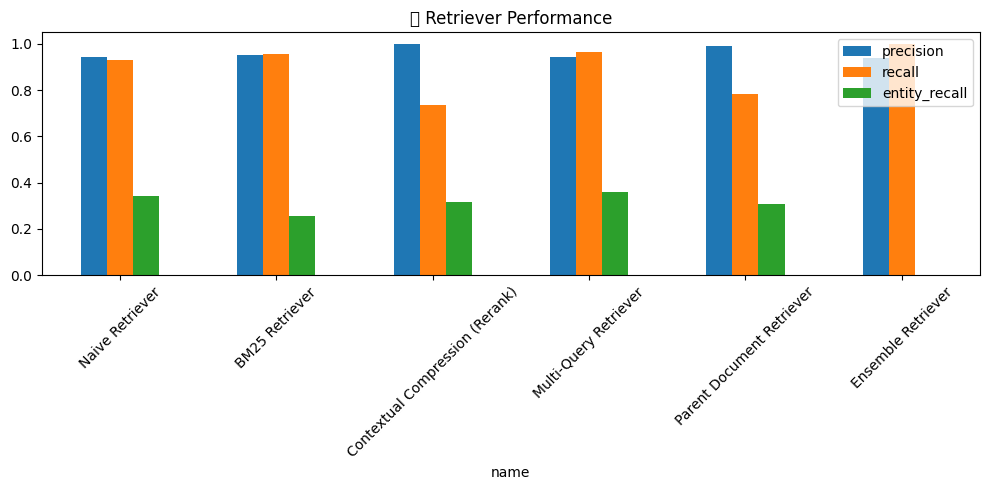

🏆 WINNER: Ensemble Retriever (Score: 1.939)
📊 RANKINGS:
6. Ensemble Retriever - 1.939
4. Multi-Query Retriever - 1.908
2. BM25 Retriever - 1.907
1. Naive Retriever - 1.874
5. Parent Document Retriever - 1.775
3. Contextual Compression (Rerank) - 1.734


In [143]:
# 📊 RESULTS ANALYSIS
import matplotlib.pyplot as plt

if 'results' in locals() and results:
    df = pd.DataFrame(results)
    df['score'] = df['precision'] + df['recall']
    
    # Simple plot
    df.set_index('name')[['precision', 'recall', 'entity_recall']].plot(kind='bar', figsize=(10, 5))
    plt.title("📊 Retriever Performance")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Winner and rankings
    winner = df.loc[df['score'].idxmax()]
    print(f"🏆 WINNER: {winner['name']} (Score: {winner['score']:.3f})")
    print("📊 RANKINGS:")
    for i, row in df.sort_values('score', ascending=False).iterrows():
        print(f"{i+1}. {row['name']} - {row['score']:.3f}")
else:
    print("❌ No results found!")